## Fig. 3 panels C, D: cluster connectivity and Jaccard coefficient

In [1]:
import sys
import pandas as pd
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
from collections import Counter
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from datetime import datetime

script_path = Path.cwd().parent.parent.parent / "script"
sys.path.append(str(script_path))
from utils.knn import *
from utils.Jaccard_coefficient import *
from utils.cluster_connections import *

output_dir = Path.cwd() / "output"
output_dir.mkdir(exist_ok=True)

c:\Users\duo.peng\Documents\Organelle_IP_figures\notebooks\Fig3\panels_C_D


### load k-NN graph and annotations

In [2]:
# timestamp = datetime.now().strftime('%Y-%m-%d')
# print(f"Timestamp: {timestamp}")    

In [3]:
# manually set the timestamp to use the intermediate results from another date
timestamp = "2023-10-21-imp5"

In [4]:
adata_path = Path.cwd().parent.parent / "Fig2" / "panel_C" / "output" / f"adata_kNN_{timestamp}.h5ad"

try:
    adata = ad.read_h5ad(adata_path)
except FileNotFoundError:
    print(f"File {adata_path} not found.\nPlease run umap analysis first (fig2 panel C) or specify the correct timestamp, current value is {timestamp}")
except pd.errors.ParserError:
    print(f"There was an error parsing the file at {adata_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# check data
print(adata)  # 8541 x 61 for reference dataset, and 8017 x 28 for remodeling data

AnnData object with n_obs × n_vars = 8541 × 61
    obs: 'Protein IDs', 'Majority protein IDs', 'Gene_name_canonical', 'organelle_ground_truth_v6.0', 'cluster_annotation', 'Graph-based_localization_annotation', 'consensus_graph_annnotation'
    var: 'mean', 'std'
    uns: 'neighbors'
    obsp: 'connectivities', 'distances'


In [5]:
# load the annotations
timestamp = "2023-10-21-imp5"
annotations_path = Path.cwd().parent.parent / "Fig2" / "panel_C" / "output" / f"{timestamp}_graph-based_annotations.csv"

try:
    annot_df = pd.read_csv(annotations_path, index_col=0)
except FileNotFoundError:
    print(f"File {annotations_path} not found.\nPlease run umap analysis first (fig2 panel C) or specify the correct timestamp, current value is {timestamp}")
except pd.errors.ParserError:
    print(f"There was an error parsing the file at {annotations_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


### preprocessing

In [6]:
#all_protein_ids = df_annot.index.to_list()
all_majority_ids = adata.obs["Majority protein IDs"].to_list()
all_genes = adata.obs["Gene_name_canonical"].to_list()

## Jaccard coefficient


In [7]:
# parameter options
norm_degrees_to_def_top_partites = True # if True, when selecting partite 1 & 2, the normalized degree is used (note that Jaccard coefficient is still computed using the raw degrees)
min_partite_deg = 3 # minimum number of degrees a node must have with a partite for the partite to be quaified for Jaccard coefficient computation
annotation_to_use = "consensus_graph_annnotation" # "cluster_annotation" or "Graph-based_localization_annotation"

the next cell take about 1.5 hours to run, and the cell is skipped if a result csv is found

In [8]:
# check if the result csv file already exists
csv_path = output_dir / f"Jaccard_Coefficient_table_PartiteNorm={norm_degrees_to_def_top_partites}_minParDeg={min_partite_deg}.csv"
if csv_path.exists():
    res_df = pd.read_csv(csv_path, index_col=0)
    print(f"File {csv_path} already exists, and loaded for subsequent analysis in this notebook.\nPlease delete it if you want to recompute the Jaccard coefficient.")
else:
    # we store the results in lists, which we will later convert to a dataframe
    # we avoid using a dataframe directly because it is slow to append rows to it
    #list_of_protein_ids = []
    list_of_majority_ids = []
    list_of_genes = []
    list_of_neighbors = []
    list_of_neighbors_annots = []
    list_of_interfacialness = []
    list_of_d1 = []
    list_of_d2 = []
    list_of_partite1 = []
    list_of_partite2 = []
    list_of_partite1_total_count = []
    list_of_partite2_total_count = []
    list_of_sorted_counts_prefilter = []

    label_total_counts = dict(Counter(annot_df[annotation_to_use]))

    # iterate over all genes and compute the Jaccard coefficient
    for idx, gene in tqdm(enumerate(all_genes), total=len(all_genes)): 
        neighbor_list, neighbor_annot_list = gene_neighbor_annots(gene_name=gene, adata=adata, annot_df=annot_df, gene_name_col="Gene_name_canonical", annot_col=annotation_to_use)
        J_coeff, d1, d2, partite1, partite2, partite1_total_count, partite2_total_count, sorted_counts_prefilter = Jaccard_Coeff_mod(neighbor_annot_list, label_total_counts,
                                                                                                                                    norm_degrees_to_def_top_partites = norm_degrees_to_def_top_partites, 
                                                                                                                                    min_partite_deg = min_partite_deg, verbose = False)
        if J_coeff != "NA":
            J_coeff = round(J_coeff,4)

        neighbors = get_neighbors(adata.copy(),gene)
        neighbors = neighbor_df_to_dict(neighbors)
        
        # write results to lists
        #list_of_protein_ids.append(all_protein_ids[idx])
        list_of_majority_ids.append(all_majority_ids[idx])
        list_of_genes.append(gene)
        list_of_neighbors.append(neighbors)
        list_of_neighbors_annots.append(neighbor_annot_list)
        list_of_interfacialness.append(J_coeff)
        list_of_d1.append(d1)
        list_of_d2.append(d2)
        list_of_partite1.append(partite1)
        list_of_partite2.append(partite2)
        list_of_partite1_total_count.append(partite1_total_count)
        list_of_partite2_total_count.append(partite2_total_count)
        list_of_sorted_counts_prefilter.append(sorted_counts_prefilter)

    # convert the jaccard coefficient results to a dataframe and write to a csv file
    res_df = pd.DataFrame({
        #"Protein IDs" : list_of_protein_ids,
        "Majority protein IDs" : list_of_majority_ids,
        "Gene_names_canonical": list_of_genes,
        "Neighbors(nn=20)": list_of_neighbors,
        "Neighbors' annotation": list_of_neighbors_annots,
        "Jaccard_Coefficient": list_of_interfacialness,
        "degrees_partite1": list_of_d1,
        "degrees_partite2": list_of_d2,
        "partite1_name": list_of_partite1,
        "partite2_name": list_of_partite2,
        "partite1_total_count": list_of_partite1_total_count,
        "partite2_total_count": list_of_partite2_total_count,
        "sorted_counts_prefilter": list_of_sorted_counts_prefilter
        })

    res_df.to_csv(output_dir / f"Jaccard_Coefficient_table_PartiteNorm={norm_degrees_to_def_top_partites}_minParDeg={min_partite_deg}.csv")


  0%|          | 0/8541 [00:00<?, ?it/s]

plot the distribution of Jaccard coefficient

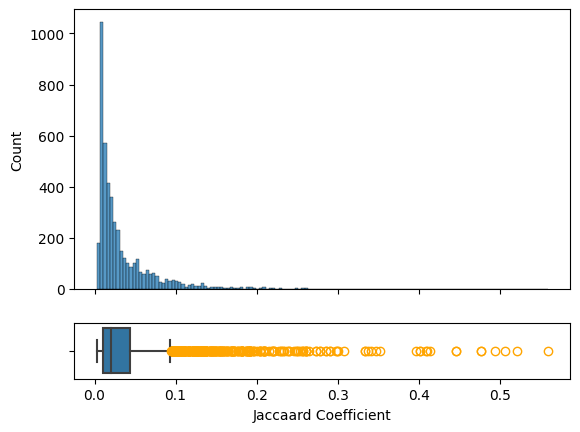

In [9]:
data = res_df[res_df["Jaccard_Coefficient"]>0]["Jaccard_Coefficient"] 

# Create grid layout
gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1])

# Histogram
ax0 = plt.subplot(gs[0])
sns.histplot(data, ax=ax0, kde=False)
ax0.set(xlabel='')
#turn off x tick labels
ax0.set_xticklabels([])

# Boxplot
ax1 = plt.subplot(gs[1])
sns.boxplot(x=data, ax=ax1, flierprops=dict(marker='o', markeredgecolor = "orange", markerfacecolor='none', markersize=6))
ax1.set(xlabel='Jaccaard Coefficient')

# Display the plot
plt.show()

## Calculate cluster connections
produces a csv file `[for_Cytoscape]cluster_connectivity.csv` to visualize as a graph in Cytoscape
the csv files contains the following columns:
- cluster1: source cluster
- cluster2: target cluster
- percent_possible_connections: percent of possible connections between the two clusters



In [10]:
# get the list of clusters
list_of_clusters = sorted(adata.obs[annotation_to_use].unique().tolist())

label_total_counts = dict(Counter(annot_df[annotation_to_use]))

# for every possible pairs of clusters, compute the connectivity
with open( output_dir / f"[for_Cytoscape]cluster_connectivity.csv", "w") as f:
    f.write("cluster1,cluster2,percent_possible_connections\n")
    for combo in tqdm(list(combinations(list_of_clusters, 2))):
        c1 = combo[0]
        c2 = combo[1]
        c1toc2, c2toc1 = clusterwise_connection(annot_df, res_df, annot_col_name = annotation_to_use ,cluster1_name = c1, cluster2_name=c2, normalize_conn = False, 
                                                restrict_to_interfacial = False ,interfacial_proteins = None)

        perc_total_conn = (c1toc2/(label_total_counts[c1]*20) + c2toc1/(label_total_counts[c2]*20))/2
        #print(f"{c1toc2}\t{c2toc1}")
        f.write(f"{c1},{c2},{perc_total_conn}\n")


  0%|          | 0/210 [00:00<?, ?it/s]